In [1]:
import xarray as xr
import cftime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import logging
import cartopy.crs as ccrs
import metpy  # accessor needed to parse crs
import calendar
import argparse
import seaborn as sns
from shapely.geometry import Point
import geopandas
from geodatasets import get_path
import glob

In [7]:
path = '/home/smmrrr/cleaned_climate_input/CMIP6'

os.chdir(path)

print(os.getcwd()) 


/home/smmrrr/cleaned_climate_input/CMIP6


In [12]:
cmip6 = glob.glob(r'*tair.csv')

len(cmip6)
# cmip6

38

In [36]:
all_runs = pd.DataFrame(columns = ['year', 'average', 'file'])
for file in cmip6:

    model = pd.read_csv(file, names = ["lon", 'lat','var' ,'Area', 'year', 'sum', 'max', 'average'
     , 'min', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'
     , 'Nov', 'Dec', 'Area_Name']
                   )
    model = model.groupby(['year'])['average'].mean()
    model=model.reset_index()
    model['file'] = file
    all_runs = pd.concat([
    model
        ,all_runs])
    print(file)
    
    
    

MRIxxESM2xx0_ssp434_tair.csv
MIROC6_ssp434_tair.csv
CanESM5_ssp434_tair.csv
CanESM5_ssp460_tair.csv
MPIxxESM1xx2xxHR_ssp126_tair.csv
MIROC6_ssp126_tair.csv
MRIxxESM2xx0_ssp126_tair.csv
AWIxxCMxx1xx1xxMR_ssp370_tair.csv
BCCxxCSM2xxMR_ssp245_tair.csv
AWIxxCMxx1xx1xxMR_ssp126_tair.csv
MIROC6_ssp119_tair.csv
MRIxxESM2xx0_ssp370_tair.csv
CanESM5_ssp585_tair.csv
MRIxxESM2xx0_ssp119_tair.csv
MIROC6_ssp370_tair.csv
MPIxxESM1xx2xxHR_ssp370_tair.csv
ACCESSxxCM2_ssp585_tair.csv
ACCESSxxCM2_ssp126_tair.csv
MRIxxESM2xx0_ssp460_tair.csv
MIROC6_ssp460_tair.csv
AWIxxCMxx1xx1xxMR_ssp585_tair.csv
MPIxxESM1xx2xxLR_ssp245_tair.csv
MRIxxESM2xx0_ssp585_tair.csv
MIROC6_ssp585_tair.csv
MPIxxESM1xx2xxHR_ssp585_tair.csv
ACCESSxxCM2_ssp370_tair.csv
CanESM5_ssp245_tair.csv
ACCESSxxCM2_ssp245_tair.csv
MPIxxESM1xx2xxLR_ssp370_tair.csv
BCCxxCSM2xxMR_ssp585_tair.csv
MPIxxESM1xx2xxLR_ssp126_tair.csv
MRIxxESM2xx0_ssp245_tair.csv
MIROC6_ssp245_tair.csv
MPIxxESM1xx2xxHR_ssp245_tair.csv
MPIxxESM1xx2xxLR_ssp585_tair.csv
BC

In [2]:
# all_runs.to_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/test_parallel_run/all_models_tair_by_year.csv')
# all_runs[['model_name', 'scenario', 'var']] = all_runs['file'].str.split('_', expand=True)
all_runs= pd.read_csv(  '/home/smmrrr/TEM_Analysis/TEM_Analysis/test_parallel_run/all_models_tair_by_year.csv')

In [3]:
all_runs[['model_name', 'scenario', 'var']] = all_runs['file'].str.split('_', expand=True)

# all_runs.loc[all_runs['model_name']=="2"]



,Unnamed: 0,year,average,file,model_name,scenario,var


In [4]:
all_runs['model_name'] = all_runs['model_name'].str.replace('xx', '-')

In [5]:
all_runs

,Unnamed: 0,year,average,file,model_name,scenario,var
0,0,1501,282.616812,AWIxxCMxx1xx1xxMR_ssp245_tair.csv,AWI-CM-1-1-MR,ssp245,tair.csv
1,1,1502,282.753788,AWIxxCMxx1xx1xxMR_ssp245_tair.csv,AWI-CM-1-1-MR,ssp245,tair.csv
2,2,1503,283.113654,AWIxxCMxx1xx1xxMR_ssp245_tair.csv,AWI-CM-1-1-MR,ssp245,tair.csv
3,3,1504,283.096715,AWIxxCMxx1xx1xxMR_ssp245_tair.csv,AWI-CM-1-1-MR,ssp245,tair.csv
4,4,1505,283.076214,AWIxxCMxx1xx1xxMR_ssp245_tair.csv,AWI-CM-1-1-MR,ssp245,tair.csv
...,...,...,...,...,...,...,...
22618,596,2096,286.288477,MRIxxESM2xx0_ssp434_tair.csv,MRI-ESM2-0,ssp434,tair.csv
22619,597,2097,286.510957,MRIxxESM2xx0_ssp434_tair.csv,MRI-ESM2-0,ssp434,tair.csv
22620,598,2098,286.463257,MRIxxESM2xx0_ssp434_tair.csv,MRI-ESM2-0,ssp434,tair.csv
22621,599,2099,286.388128,MRIxxESM2xx0_ssp434_tair.csv,MRI-ESM2-0,ssp434,tair.csv


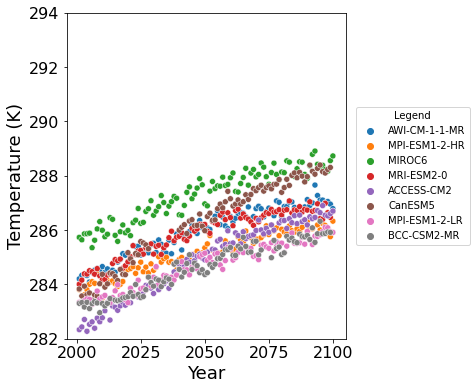

In [27]:
fig, ax = plt.subplots(figsize=(5,6))

# Use seaborn scatterplot
sns.scatterplot(
    data=all_runs.loc[(all_runs['year']>2000) & (all_runs['scenario']=='ssp245')],
    x='year',
    y='average',
    # style='scenario',
    # # markers={'A': 's', 'B': 'o'},  # Set marker shape based on shape_group
    hue='model_name',
    # size = 16,
    # # palette={'X': 'red', 'Y': 'green', 'Z': 'blue'},  # Set color based on color_group
    # legend='full',
    ax=ax
)

# Set plot title and labels
# ax.set_title('CMIP6 Annual Air Temperature', fontsize = 26)
ax.set_xlabel('Year', fontsize = 18)
ax.set_ylabel('Temperature (K)', fontsize = 18)
ax.set_ylim(282,294)
legend = ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), title='Legend')
ax.tick_params(axis='both', labelsize=16)
# legend.get_texts()[0].set_fontsize('x-large')
# Adjust the figure layout
# plt.tight_layout(rect=[0, 0, 0.85, 1])

# Show the plot
plt.show()
